# Exploring Practical Recommendation Systems In Neo4j
### __An Example With Collaborative Leveraging Graph Data Science and Machgine Learning__

In this notebook we explore how to get started with practical & scalable recommendation in graph. We will walk through a fundamental example with recipe recommendation on dataset containing 231k recipes and around 226K users. We will leverage Neo4j and the Graph Data Science (GDS) library to quickly predict similar recipes based on user preferences and enable sub-second, rank-ordered, recommendation queries personalized to each user.

This notebook is structured as follows: 

1. setup some configurations and helper functions to allow us to work with the graph. 
2. Go over the source dataset and graph we will be using along with how to query basic profiling statistics to help us understand the graph and better prepare for analysis. 
3. Briefly introduce a technique called Collaborative filtering (CF) which will be our mechanism for recommendation in this notebook
4. Explore Applying the Cypher query language for basic CF
5. Scaling CF with the Graph Data Science (GDS) Library, leveraging Node embeddings and an ML technique called K-Nearest Neighbor (KNN).

## Notebook Setup

In [103]:
from graphdatascience import GraphDataScience
import pandas as pd
import numpy as np
import configparser
import os
import time
import matplotlib.pyplot as plt
pd.set_option('display.width', 0)
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 12)

### Neo4j Settings
The `NEO4J_PROPERTIES_FILE` is an ini configuration file for Neo4j properties so this notebook can connect to
your Neo4j instance and load data. The ini file should be formatted as follows
```
[NEO4J]
PASSWORD=<password>
USERNAME=<database name, is 'neo4j' by default>
HOST=<host uri>

```

Set `NEO4J_PROPERTIES_FILE` to None or any non-existent location to use the below defaults
```
HOST = 'neo4j://localhost'
USERNAME = 'neo4j'
PASSWORD = 'password'
```

In [2]:
NEO4J_PROPERTIES_FILE = None #'/path/to/your/file.ini'

In [3]:
# Using an ini file for credentials, otherwise providing defaults
HOST = 'bolt://localhost:7687'
DATABASE = 'neo4j'
PASSWORD = 'LU?vVtYf8])9;^z'

if NEO4J_PROPERTIES_FILE is not None and os.path.exists(NEO4J_PROPERTIES_FILE):
    config = configparser.RawConfigParser()
    config.read(NEO4J_PROPERTIES_FILE)
    HOST = config['NEO4J']['HOST']
    USERNAME = config['NEO4J']['USERNAME']
    PASSWORD = config['NEO4J']['PASSWORD']
    print('Using custom database properties')
else:
    print('Could not find database properties file, using defaults')

Could not find database properties file, using defaults


In [4]:
gds = GraphDataScience(HOST, auth=(DATABASE, PASSWORD))

### Helper Functions

In [5]:
class GraphQueryError(Exception):
    def __init__(self, message):
        self.message = message


def run(driver, query, params=None):
    with driver.session() as session:
        if params is not None:
            return [r for r in session.run(query, params)]
        else:
            return [r for r in session.run(query)]

def degree_counts(node_label, relationship_type, direction='BOTH'):
    dr = direction.upper()
    if dr not in {'BOTH', 'IN', 'OUT'}:
        raise GraphQueryError(f"direction must be one of {{'BOTH', 'IN', 'OUT'}}, but got {dr}")

    if dr == 'BOTH':
        pattern = f'[(n)-[:{relationship_type}]-() | n]'
    elif dr == 'OUT':
        pattern = f'[(n)-[:{relationship_type}]->() | n]'
    else:
        pattern = f'[(n)<-[:{relationship_type}]-() | n]'

    df= gds.run_cypher( f'''
            MATCH (n:{node_label}) WITH id(n) as nodeIds, size({pattern}) AS degree
            RETURN degree, count(degree) AS degreeCount ORDER BY degree
        ''')

    df['csum'] = df.degreeCount.cumsum()
    n = df.degreeCount.sum()
    df['percentile'] = df.csum/n
    return df.drop(columns=['csum'])

def get_percentiles(df, q=None):
    if q is None:
        q = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
    q_name = ['min'] + [f'p{int(100*i)}' for i in q] + ['max']
    p = [df.degree.min()] + [df.degree[df.percentile >= i].iloc[0] for i in q] + [df.degree.max()]
    p_df = pd.DataFrame(np.column_stack((q_name, p)), columns=['q', 'percentile'])
    return p_df.set_index('q')

```
//visualize schema in Neo4j Browser
neo4j$ CALL db.schema.visualization();
```
![image](./image/nodes.png)

We see that recipes are modeled as nodes and can can be "created" or "reviewed" by users which are also modeled as nodes. 
Additionally, News also have ingredients and it's relation with recipe. These will be useful for extended analysis, but we will not be using them in this example. Our primary interest here is to get started with users and their reviews to derive recommendations.

### Graph Data Profiling
Before diving right into into analysis, it is helpful to inspect some high level statistics of graph to get a better sense of size and connectivity.

#### Aggregate Counts
Let's start with high node and relationships counts. These functions assume [APOC](https://neo4j.com/developer/neo4j-apoc/) is installed on your Neo4j DB.

In [6]:
# total node counts
gds.run_cypher( '''
    CALL apoc.meta.stats()
    YIELD labels AS nodeCounts
    UNWIND keys(nodeCounts) AS label
    WITH label, nodeCounts[label] AS nodeCount
    WHERE label IN ['User','Recipe']
    RETURN label, nodeCount
''')

,label,nodeCount
0,User,226570
1,Recipe,231637


In [7]:
# total relationship counts
gds.run_cypher( '''
    CALL apoc.meta.stats()
    YIELD relTypesCount as relationshipCounts
    UNWIND keys(relationshipCounts) AS type
    WITH type, relationshipCounts[type] AS relationshipCount
    WHERE type IN ['REVIEWED','CREATED']
    RETURN type, relationshipCount
''')

,type,relationshipCount
0,CREATED,213598
1,REVIEWED,300000


As far as search recommendation is concerns this is a relatively modestly sized graph, with only around 226K users, 231k news articles, and around 500k total creations/reviews.

#### Reviews Distributions
Next, we can look at the distribution of events per user. It is helpful to check this distribution to make sure that:
1. The graph is reasonably well connected as the quality of our upcoming recommendation technique will depend on a reasonably well connected graph.
2. We do not have any large [supernodes](https://medium.com/neo4j/graph-modeling-all-about-super-nodes-d6ad7e11015b), i.e. nodes with very high numbers of relationships. What qualifies as a supernode varies greatly by use case. For this, I would be concerned about users with tens of thousands of clicks.

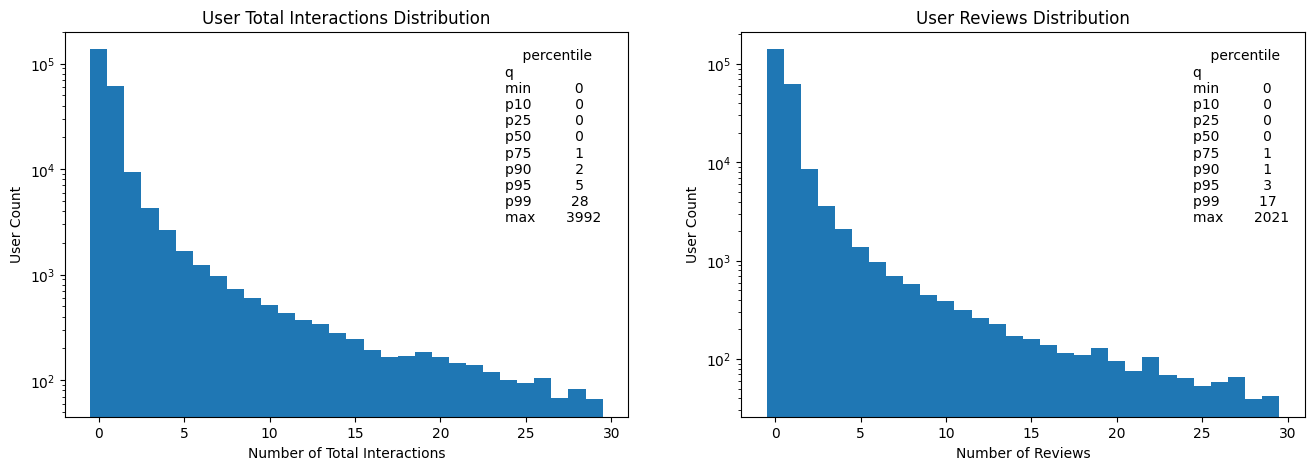

In [8]:
all_interactions_df = degree_counts( 'User', 'REVIEWED|CREATED', 'OUT')
reviews_df = degree_counts('User', 'REVIEWED', 'OUT')

f, axs = plt.subplots(1,2,figsize=(16,5))

axs[0].bar(all_interactions_df.degree[:30], all_interactions_df.degreeCount[:30], width=1, log=True)
axs[0].set_title('User Total Interactions Distribution')
axs[0].set_ylabel('User Count')
axs[0].set_xlabel('Number of Total Interactions')
plt.figtext(0.4, 0.5, get_percentiles(all_interactions_df).to_string())


axs[1].bar(reviews_df.degree[:30], reviews_df.degreeCount[:30], width=1, log=True)
axs[1].set_title('User Reviews Distribution')
axs[1].set_ylabel('User Count')
axs[1].set_xlabel('Number of Reviews')
plt.figtext(0.83, 0.5, get_percentiles(reviews_df).to_string())

plt.show()

The above shows the distributions for total interactions (`REVIEWED` and `CREATED`) as well as reviews (just `REVIEWED`) by user. We see that the distributions have heavy left tails, showing that activity is not uniformly distributed among users, but rather there is relatively small fraction of users that account for a large number of interactions. This is somewhat expected. 

We can do a similar breakdown for Recipe below.

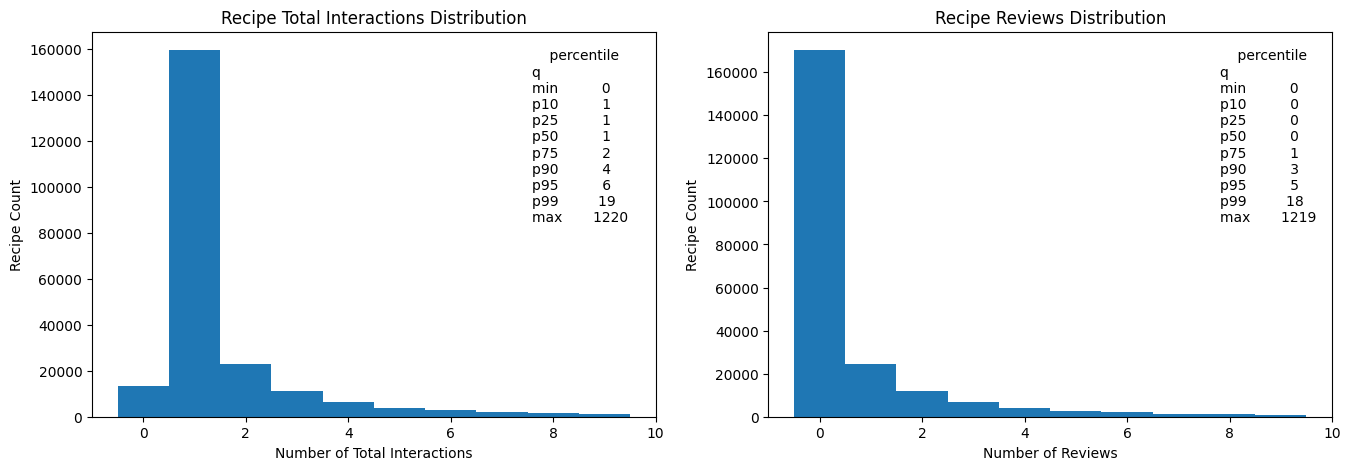

In [9]:
all_interactions_df = degree_counts('Recipe', 'REVIEWED|CREATED', 'IN')
reviews_df = degree_counts('Recipe', 'REVIEWED', 'IN')

f, axs = plt.subplots(1,2,figsize=(16,5))

axs[0].bar(all_interactions_df.degree[:10], all_interactions_df.degreeCount[:10], width=1)
axs[0].set_title('Recipe Total Interactions Distribution')
axs[0].set_ylabel('Recipe Count')
axs[0].set_xlabel('Number of Total Interactions')
plt.figtext(0.4, 0.5, get_percentiles(all_interactions_df).to_string())


axs[1].bar(reviews_df.degree[:10], reviews_df.degreeCount[:10], width=1)
axs[1].set_title('Recipe Reviews Distribution')
axs[1].set_ylabel('Recipe Count')
axs[1].set_xlabel('Number of Reviews')
plt.figtext(0.83, 0.5, get_percentiles(reviews_df).to_string())

plt.show()

## Collaborative Filtering (CF)

There are many different types of recommendations systems. In this example we will apply a technique called Collaborative Filtering (CF), which is the practice of automatically predicting a user's preferences based on the actions of similar users.

### User vs Item Based CF
Roughly speaking there are two main classes of collaborative filtering
1. User-based, which is focuses on directly calculating similarity between users based on their interaction with items
2. Item-based, which measures the similarity between pairs of items based on correlated user activity, such as the same users liking, viewing, rating, or otherwise similarly interacting with items

Our approach today will focus on the later, item-based CF. Item-based CF will be more manageable and scalable then user-based CF for many problem domains. There are a couple reasons for this. First, because there are way fewer items then users in most applied cases so there are less entities to compare. Second, and perhaps more importantly, User preferences can also be dynamic and change overtime. For example, in a Movie example, a user could be mostly interested in Sci Fi movies but go through a brief stint in Westerns, and making recommendations for Westerns to other Sci Fi fans who historically viewed the same things may not be the best thing. Often the best indicator of a user's current interest is their most recent activity, and item based filtering gives you better flexibility to find similarities based off the most recent item(s) created, rated, etc.

## Basic Cypher Queries for CF
From here we could try just using Cypher to accomplish basic Collaborative Filtering. For example, take the below user and the news they clicked. You can see a mixed interest between autos, finance, US news, and a couple other categories.

In [90]:
# Select a random user that has at least n_reviews reviews
random_user = gds.run_cypher('''
    MATCH (user:User)-[:REVIEWED]->(:Recipe)
    WITH user, COUNT(*) AS reviewCount
    WHERE reviewCount >= $n_reviews
    WITH user, RAND() AS randomOrder
    ORDER BY randomOrder
    RETURN user.id AS randomUserID
    LIMIT 1
''', params={'n_reviews': 10})['randomUserID'][0]

USER_ID = f'{random_user}'

print(f"Selected user {USER_ID}")

Selected user 536944


In [91]:
gds.run_cypher('''
    MATCH (u1:User {id: $userId})
           -[r1:CREATED|REVIEWED]->(re1:Recipe)
    RETURN re1.id AS recipeID,
           re1.name AS name,
           re1.tags AS tags,
           re1.nutrition AS nutrition,
           re1.n_ingredients As n_ingredients,
           COALESCE(r1.submitted, r1.date) AS impressionTime,
           type(r1) AS interactionType
    ORDER BY interactionType, impressionTime DESC
    ''', params={'userId': USER_ID})


,recipeID,name,tags,nutrition,n_ingredients,impressionTime,interactionType
0,117496,chewy gingersnaps sparkle cookies,"['30-minutes-or-less', 'time-to-make', 'course', 'preparation', 'occasion', 'hand-formed-cookies', 'desserts', 'easy', 'beginner-cook', 'cookies-and-brownies', 'gifts', 'inexpensive']","[120.0, 7.0, 39.0, 7.0, 2.0, 14.0, 6.0]",12,2010-01-08,REVIEWED
1,214643,amaranth for breakfast,"['30-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'preparation', 'for-1-or-2', 'breakfast', 'vegetarian', 'grains', 'dietary', 'low-sodium', 'low-in-something', 'pasta-rice-and-grains', 'number-of-servings']","[333.1, 19.0, 72.0, 0.0, 15.0, 46.0, 16.0]",5,2009-10-03,REVIEWED
2,350894,kittencal s thick and rich creamy tomato soup low fat option,"['time-to-make', 'course', 'main-ingredient', 'preparation', 'occasion', 'low-protein', 'bisques-cream-soups', 'soups-stews', 'vegetables', 'easy', 'beginner-cook', 'dinner-party', 'holiday-event', 'kid-friendly', 'vegetarian', 'winter', 'stove-top', 'dietary', 'christmas', 'low-cholesterol', 'seasonal', 'low-calorie', 'comfort-food', 'low-carb', 'inexpensive', 'healthy-2', 'low-in-something', 'tomatoes', 'taste-mood', 'equipment', '4-hours-or-less']","[124.1, 8.0, 20.0, 23.0, 7.0, 17.0, 5.0]",14,2009-04-24,REVIEWED
3,261889,kittencal s buttery cut out sugar cookies w icing that hardens,"['time-to-make', 'course', 'main-ingredient', 'preparation', 'occasion', 'for-large-groups', 'rolled-cookies', 'desserts', 'eggs-dairy', 'oven', 'easy', 'refrigerator', 'beginner-cook', 'holiday-event', 'kid-friendly', 'cookies-and-brownies', 'dietary', 'christmas', 'taste-mood', 'sweet', 'equipment', 'number-of-servings', '4-hours-or-less']","[144.2, 8.0, 50.0, 4.0, 3.0, 17.0, 7.0]",13,2009-02-13,REVIEWED
4,15220,olive garden salad dressing,"['15-minutes-or-less', 'time-to-make', 'course', 'preparation', 'occasion', 'for-large-groups', 'salads', 'easy', 'no-cook', 'salad-dressings', 'dietary', 'copycat', 'novelty', 'number-of-servings', '3-steps-or-less', 'technique']","[16.9, 1.0, 2.0, 0.0, 1.0, 1.0, 0.0]",10,2009-01-17,REVIEWED
5,15654,overnight eggnog baked french toast,"['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'occasion', 'north-american', 'breakfast', 'eggs-dairy', 'canadian', 'oven', 'holiday-event', 'eggs', 'freezer', 'dietary', 'christmas', 'low-sodium', 'oamc-freezer-make-ahead', 'low-in-something', 'equipment', 'number-of-servings']","[303.3, 26.0, 75.0, 10.0, 25.0, 44.0, 8.0]",11,2008-12-25,REVIEWED
6,98447,cha ching carrot spice muffins,"['30-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'north-american', 'breads', 'vegetables', 'oven', 'muffins', 'dietary', 'quick-breads', 'carrots', 'equipment', 'number-of-servings']","[135.3, 10.0, 34.0, 5.0, 5.0, 4.0, 6.0]",16,2008-12-20,REVIEWED
7,55796,healthy bean soup with kale,"['30-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'preparation', 'occasion', 'low-protein', 'healthy', 'lunch', 'main-dish', 'soups-stews', 'beans', 'vegetables', 'easy', 'potluck', 'fall', 'low-fat', 'picnic', 'winter', 'stove-top', 'dietary', 'low-cholesterol', 'seasonal', 'low-saturated-fat', 'low-calorie', 'low-carb', 'inexpensive', 'healthy-2', 'low-in-something', 'greens', 'brunch', 'to-go', 'equipment', 'presentation', 'served-hot']","[214.6, 5.0, 42.0, 32.0, 23.0, 3.0, 12.0]",12,2008-09-05,REVIEWED
8,250065,ww fettuccine alfredo,"['60-minutes-or-less', 'time-to-make', 'course', 'main-ingredient', 'cuisine', 'preparation', 'occasion', 'main-dish', 'pasta', 'european', 'italian', 'dietary', 'one-dish-meal', 'comfort-food', 'pasta-rice-and-grains', 'taste-mood']","[442.9, 25.0, 25.0, 24.0, 47.0, 44.0, 16.0]",9,2008-08-26,REVIEWED
9,214051,tsr version of starbucks pumpkin scones by todd wilbur,"['30-minutes-or-less', 'time-to-make', 'course', 'preparation', 'occasion', 'healthy', 'breads', 'breakfast', 'holiday-event', 'dietary', 'copycat', 'thank

Assuming we can measure the similarity of user interests via commonly reviewed recipes, we can do a three hop query to find potential recommendations for user `27711` based on the activity of users that reviewed the same recipe as `27711` (or even reviewed their recipe high).

With the below query we can get an aggregate count of the nodes we would need to traverse over to get the recommendations.

In [92]:
gds.run_cypher('''
    MATCH (u1:User {id: $userId})
           -[r1:REVIEWED]->(re1:Recipe)
           <-[r2:REVIEWED]-(u2:User)
           -[r3:REVIEWED]->(re2:Recipe)
    RETURN u1.id AS userId,
           count(DISTINCT re1) AS reviewedRecipes,
           count(DISTINCT u2) AS likeUsers,
           count(DISTINCT re2) AS potentialRecommendations
    ''', params={'userId': USER_ID})

,userId,reviewedRecipes,likeUsers,potentialRecommendations
0,536944,11,773,20072


While the above can work well in some cases, and while it can certainly be a massive improvement from joining SQL tables or cross-walking over document stores, notice that we get a lot of potential recommendations back (about 13K). And this is just a sample of the the total dataset.

For production use cases where recommendations will need to be queried frequently, this method will have trouble scaling as the number of users, amount of content, and/or observed engagement grows. We need some other strategy to help narrow down the results. There are a few different ways we can accomplish this, but one robust and scalable way to do so is with the [Neo4j Graph Data Science (GDS) Library](https://neo4j.com/docs/graph-data-science/current/).

### Recommendation based on favorite ingredients
First let's make a list of excluded ingredients. Those ingredients won't be considered as they're common ingredients in recipies.

In [113]:
excluded_ingr = ['butter', 'salt', 'sugar', 'all-purpose flour', 'baking powder', 'baking soda']

In [114]:
start_time = time.time()

# Compute top 5 user ingredients
print(gds.run_cypher('''
    MATCH (user:User {id: $userId})-[rew:REVIEWED]->(recipe:Recipe)-[:WITH_INGREDIENTS]->(ingredient:Ingredient)
    WHERE rew.rating = 5 AND NOT ingredient.name IN $excluded_ingr
    WITH ingredient, COUNT(recipe) AS reviewCount
    ORDER BY reviewCount DESC
    LIMIT $limit
    RETURN ingredient.name AS favoriteIngredient, reviewCount
    ''', params={'userId': USER_ID, 'limit': 5, 
                 'excluded_ingr': excluded_ingr}))

end_time = time.time()

print(f'\nQuery executed in {end_time-start_time:.2f} seconds')

  favoriteIngredient  reviewCount
0            vanilla            4
1      garlic cloves            3
2               eggs            3
3           cinnamon            3
4    parmesan cheese            3

Query executed in 0.02 seconds


In [115]:
start_time = time.time()

# Suggest recipes based on user's favorites ingredients
print(gds.run_cypher('''
    MATCH (user:User {id: $userId})-[rew :REVIEWED]->(:Recipe)-[:WITH_INGREDIENTS]->(ingredient:Ingredient)  
    WHERE rew.rating = 5 AND NOT ingredient.name IN $excluded_ingr
    WITH ingredient, COUNT(*) AS ingredientCount
    ORDER BY ingredientCount DESC
    LIMIT $limitIngr
    WITH COLLECT(ingredient) AS favoriteIngredients
    MATCH (recipe:Recipe)-[:WITH_INGREDIENTS]->(ingredient:Ingredient)
    WHERE ingredient IN favoriteIngredients
    WITH recipe, COLLECT(ingredient.name) AS recipeIngredients
    RETURN recipe.id AS recipeID, recipe.name AS recipeName, recipeIngredients
    LIMIT $limit
    ''', params={
        'userId': USER_ID, 'limit': 5, 'limitIngr':5, 
        'excluded_ingr': excluded_ingr}))

end_time = time.time()

print(f'\nQuery executed in {end_time-start_time:.2f} seconds')

  recipeID                          recipeName          recipeIngredients
0   111625                      22 minute cake  [eggs, vanilla, cinnamon]
1    94694      zucchini mandarin orange bread            [eggs, vanilla]
2   232200  zucchini yogurt multigrain muffins                     [eggs]
3    95938            zucchini pistachio bread           [eggs, cinnamon]
4    35975                      zucchini bread                     [eggs]

Query executed in 0.14 seconds


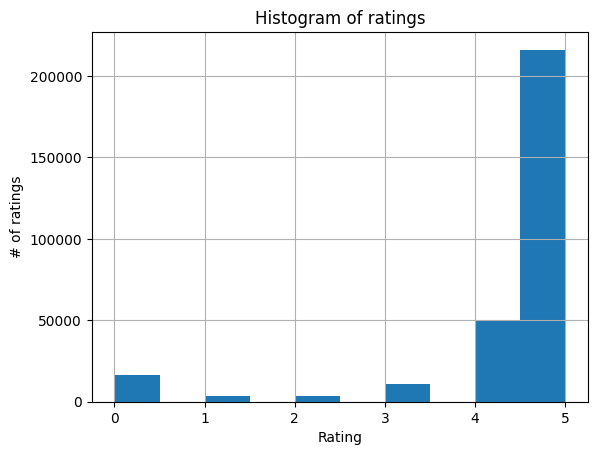

In [126]:
# Extract all ratings
ratings = gds.run_cypher('''
    MATCH (:User)-[r:REVIEWED]->(:Recipe)
    RETURN r.rating AS rating
    ''')

# Create an histogram
ratings['rating'].hist()

# Add labels and title
plt.xlabel('Rating')
plt.ylabel('# of ratings')
plt.title('Histogram of ratings')
plt.show()